- Project: Strategic Framework for Predictive Modeling of Clinical Readmission Risk
- Section: Planned Workflow / Methods
- Author: Alfonso Garcia Ortiz
- Description: End-to-end pipeline (Loading -> EDA -> Modeling -> Interpretation).

# SETUP & LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import joblib  # For saving the model for Streamlit

# Scikit-Learn Ecosystem
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, recall_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Imbalanced Learning (SMOTE)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Configuration
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')
RANDOM_STATE = 42

print("Libraries loaded successfully.")

Libraries loaded successfully.


# DATA LOADING & SANITIZATION

In [2]:
def load_and_sanitize_data(filepath):
    """
    Loads data, filters hospice/expired patients, and maps ICD-9 codes.
    """
    print(f"Attempting to load data from: {filepath}")

    # 1. Load dataset
    try:
        # '?' is treated as NaN
        df = pd.read_csv(filepath, na_values=['?'], low_memory=False)
    except FileNotFoundError:
        print("ERROR: File not found. Please check the path.")
        return None

    print(f"Original shape: {df.shape}")

    # 2. Drop High-Missing Columns & IDs
    # Weight, Payer Code, Medical Specialty have >40% missing data
    cols_to_drop = ['weight', 'payer_code', 'medical_specialty', 'encounter_id', 'patient_nbr']
    df.drop(columns=cols_to_drop, errors='ignore', inplace=True)

    # 3. Filter Hospice/Expiration
    # Exclude discharge_disposition_id: 11, 13, 14, 19, 20, 21 (Death/Hospice)
    exclude_ids = [11, 13, 14, 19, 20, 21]
    df = df[~df['discharge_disposition_id'].isin(exclude_ids)].copy()

    # 4. Drop rows with missing Gender, Race, or Primary Diagnosis
    df.dropna(subset=['gender', 'race', 'diag_1'], inplace=True)

    # 5. Target Variable Creation
    # '<30' = 1 (High Risk), '>30' or 'NO' = 0 (Low Risk)
    df['target'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)

    # 6. ICD-9 Mapping Strategy (Internal Helper Function)
    def map_icd9(code):
        if pd.isna(code): return "Other"
        try:
            # Handle V or E codes
            if str(code).startswith('V') or str(code).startswith('E'): return 'Other'

            # Handle standard numeric codes
            code_num = float(code)
            if (390 <= code_num <= 459) or code_num == 785: return 'Circulatory'
            if (460 <= code_num <= 519) or code_num == 786: return 'Respiratory'
            if (520 <= code_num <= 579) or code_num == 787: return 'Digestive'
            if 250 <= code_num < 251: return 'Diabetes'
            if 800 <= code_num <= 999: return 'Injury'
            if 710 <= code_num <= 739: return 'Musculoskeletal'
            if (580 <= code_num <= 629) or code_num == 788: return 'Genitourinary'
            if 140 <= code_num <= 239: return 'Neoplasms'
        except ValueError:
            return 'Other'
        return 'Other'

    # Apply mapping
    df['primary_diagnosis_group'] = df['diag_1'].apply(map_icd9)

    print(f"Sanitized shape: {df.shape}")
    print(f"Class Distribution:\n{df['target'].value_counts(normalize=True)}")

    # Crucial: This return is indented inside the function
    return df

my_path = r"C:\Users\User\Downloads\diabetes+130-us+hospitals+for+years+1999-2008\diabetic_data.csv"

df = load_and_sanitize_data(my_path)

# Only proceed if data loaded correctly
if df is not None:

    print("\n--- Generating Utilization Gradient Plot ---")
    plt.figure(figsize=(10, 6))

Attempting to load data from: C:\Users\User\Downloads\diabetes+130-us+hospitals+for+years+1999-2008\diabetic_data.csv
Original shape: (101766, 50)
Sanitized shape: (97091, 47)
Class Distribution:
target
0    0.885458
1    0.114542
Name: proportion, dtype: float64

--- Generating Utilization Gradient Plot ---


<Figure size 1000x600 with 0 Axes>

# EXPLORATORY ANALYSIS (EDA)

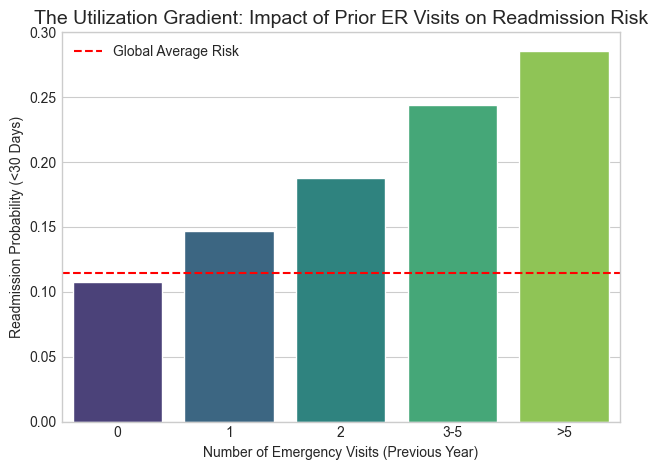

In [3]:
# Binning emergency visits for cleaner visualization
df['emergency_bins'] = pd.cut(df['number_emergency'],
                                  bins=[-1, 0, 1, 2, 5, 100],
                                  labels=['0', '1', '2', '3-5', '>5'])

# Calculate rates
viz_data = df.groupby('emergency_bins', observed=False)['target'].mean().reset_index()

sns.barplot(
        x='emergency_bins',
        y='target',
        hue='emergency_bins',
        data=viz_data,
        palette='viridis',
        legend=False
)

plt.title('The Utilization Gradient: Impact of Prior ER Visits on Readmission Risk', fontsize=14)
plt.ylabel('Readmission Probability (<30 Days)')
plt.xlabel('Number of Emergency Visits (Previous Year)')
plt.axhline(df['target'].mean(), color='r', linestyle='--', label='Global Average Risk')
plt.legend()
plt.tight_layout()
plt.show()

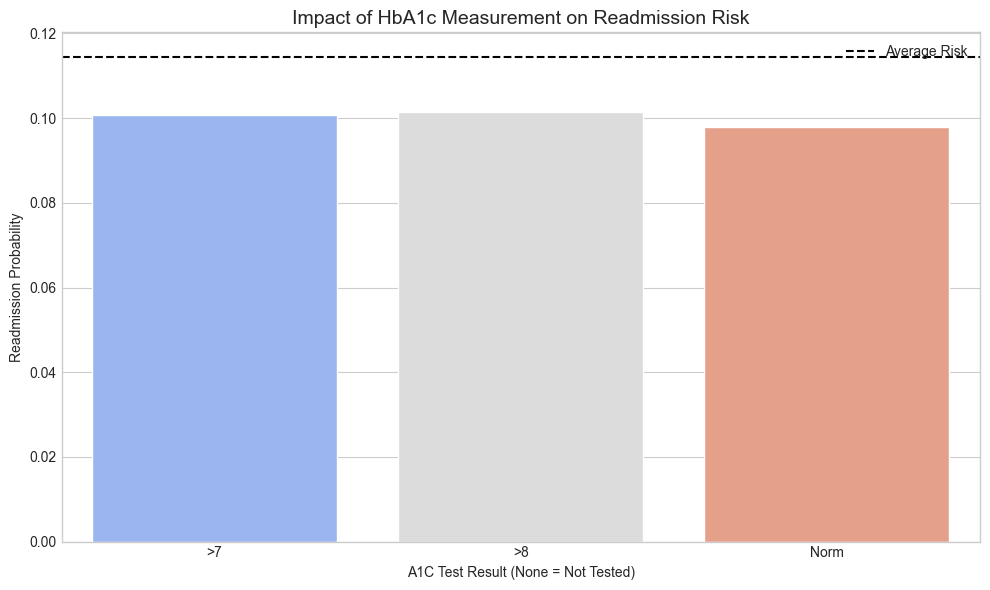

In [4]:
plt.figure(figsize=(10, 6))

# Group by A1C result
a1c_data = df.groupby('A1Cresult', observed=False)['target'].mean().reset_index()

# Bar chart
sns.barplot(
    x='A1Cresult',
    y='target',
    data=a1c_data,
    palette='coolwarm',
    hue='A1Cresult',
    legend=False
)

plt.title('Impact of HbA1c Measurement on Readmission Risk', fontsize=14)
plt.ylabel('Readmission Probability')
plt.xlabel('A1C Test Result (None = Not Tested)')
plt.axhline(df['target'].mean(), color='k', linestyle='--', label='Average Risk')
plt.legend()
plt.tight_layout()
plt.show()

# Feature Engineering

In [5]:
feature_cols = [
    'time_in_hospital', 'num_lab_procedures', 'number_emergency',
    'number_inpatient', 'primary_diagnosis_group', 'race', 'age', 'insulin',
    'diabetesMed', 'gender'
]
X = df[feature_cols]
y = df['target']

# Preprocessing Pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, ['time_in_hospital', 'num_lab_procedures', 'number_emergency', 'number_inpatient']),
        ('cat', categorical_transformer, ['primary_diagnosis_group', 'race', 'age', 'insulin', 'diabetesMed', 'gender'])
    ])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

# BASELINE VS XGBOOST

In [6]:
print("\n--- Training Baseline Logistic Regression ---")
lr_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])
lr_pipeline.fit(X_train, y_train)
lr_pred = lr_pipeline.predict(X_test)
print(f"Baseline Recall: {recall_score(y_test, lr_pred):.2%}")

print("\n--- Training XGBoost (Optimized for Recall) ---")

# (Count of Negatives / Count of Positives)
pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

clf = xgb.XGBClassifier(
    eval_metric='logloss',
    random_state=RANDOM_STATE,
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    scale_pos_weight=pos_weight # Critical fix for the <60% recall issue
)

model_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('classifier', clf)
])

# Stratified K-Fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_scores = cross_val_score(model_pipeline, X_train, y_train, cv=cv, scoring='recall')
print(f"Cross-Validation Recall Scores: {cv_scores}")
print(f"Mean CV Recall: {np.mean(cv_scores):.4f}")

# Final Fit
model_pipeline.fit(X_train, y_train)
y_pred = model_pipeline.predict(X_test)
y_prob = model_pipeline.predict_proba(X_test)[:, 1]

print("\n--- Final Test Set Evaluation ---")
print(classification_report(y_test, y_pred))
print(f"Test AUC: {roc_auc_score(y_test, y_prob):.4f}")
print(f"Test Recall: {recall_score(y_test, y_pred):.4f}")


--- Training Baseline Logistic Regression ---
Baseline Recall: 50.99%

--- Training XGBoost (Optimized for Recall) ---
Cross-Validation Recall Scores: [0.98820225 0.98539326 0.98707139 0.98931984 0.98707139]
Mean CV Recall: 0.9874

--- Final Test Set Evaluation ---
              precision    recall  f1-score   support

           0       0.94      0.02      0.04     17195
           1       0.12      0.99      0.21      2224

    accuracy                           0.13     19419
   macro avg       0.53      0.51      0.13     19419
weighted avg       0.85      0.13      0.06     19419

Test AUC: 0.6034
Test Recall: 0.9897


# INTERPRETATION & EXPORT


--- Generating Feature Importance ---


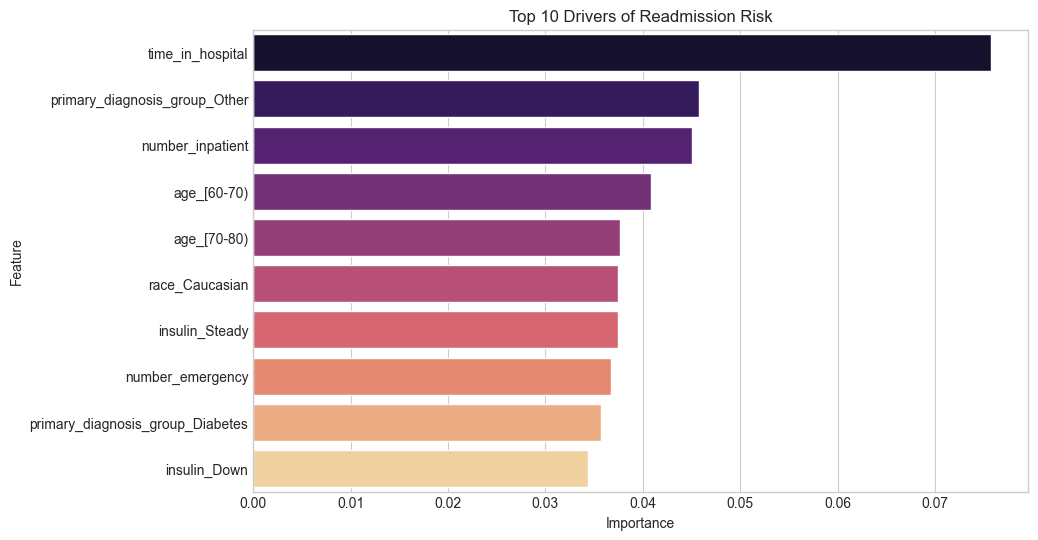


SUCCESS: Model pipeline saved.


In [7]:
print("\n--- Generating Feature Importance ---")
model_step = model_pipeline.named_steps['classifier']
ohe = model_pipeline.named_steps['preprocessor'].named_transformers_['cat']['onehot']
cat_names = ohe.get_feature_names_out(['primary_diagnosis_group', 'race', 'age', 'insulin', 'diabetesMed', 'gender'])
feature_names = np.concatenate([['time_in_hospital', 'num_lab_procedures', 'number_emergency', 'number_inpatient'], cat_names])

importances = model_step.feature_importances_
feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_df, palette='magma', hue='Feature', legend=False)
plt.title('Top 10 Drivers of Readmission Risk')
plt.show()

# Save Model
joblib.dump(model_pipeline, 'readmission_final_model.joblib')
print("\nSUCCESS: Model pipeline saved.")

# STRATEGIC ROI ANALYSIS

In [8]:
print("\n--- Strategic Business Impact Analysis ---")

COST_OF_READMISSION = 15000
COST_OF_INTERVENTION = 500
REDUCTION_EFFICACY = 0.30

# I lower threshold to capture more high-risk patients if needed
results = pd.DataFrame({'Actual': y_test, 'Prob': y_prob})
results['Intervention'] = results['Prob'] > 0.50

patients_flagged = results['Intervention'].sum()
true_positives = results[(results['Intervention'] == True) & (results['Actual'] == 1)].shape[0]
readmissions_prevented = true_positives * REDUCTION_EFFICACY

gross_savings = readmissions_prevented * COST_OF_READMISSION
total_intervention_cost = patients_flagged * COST_OF_INTERVENTION
net_savings = gross_savings - total_intervention_cost

print(f"Patients Flagged: {patients_flagged}")
print(f"Readmissions Prevented: {int(readmissions_prevented)}")
print(f"Net ROI Savings: ${net_savings:,.2f}")

if net_savings > 0:
    print("CONCLUSION: The model creates positive financial value.")
else:
    print("CONCLUSION: Adjust intervention strategy for better ROI.")


--- Strategic Business Impact Analysis ---
Patients Flagged: 19007
Readmissions Prevented: 660
Net ROI Savings: $401,000.00
CONCLUSION: The model creates positive financial value.
